# Milestone 1: Data acquisition, Data preparation

# 1. Data Source, Installation and Data Integration

The data that will be used in the development of this project is the [Dataset of Speech Production in intracranial Electroencephalography](https://www.nature.com/articles/s41597-022-01542-9), this dataset can be downloaded from [here](https://osf.io/nrgx6/download) and then was uploaded to google drive.

The dataset is based on 10 participants reading out individual words while being measured his intracranial EEG from a total of 1103 electrodes. It has a high temporal resolution and coverage of a large variety of cortical and sub-cortical brain regions, can help in understanding the speech production process better.

In [1]:
# This command installs all the necessary dependencies listed in the requirements.txt file.
# Ensure you have an internet connection so that pip can download the packages.

!pip install -r https://raw.githubusercontent.com/acuadrosr18/Brain-to-Speech-Synthesis-Project_DeepLearning/main/requirements.txt

ERROR: Could not find a version that satisfies the requirement sklearn==1.2.2 (from versions: 0.0, 0.0.post1, 0.0.post2, 0.0.post4, 0.0.post5, 0.0.post7, 0.0.post9, 0.0.post10, 0.0.post11)
ERROR: No matching distribution found for sklearn==1.2.2


In [2]:
# Install every library that we will need for the development of the project

!pip install numpy scipy scikit-learn pandas pynwb nilearn nibabel RutishauserLabtoNWB pytorch-lightning --quiet


In [3]:
import numpy as np
import scipy
import sklearn
import pandas as pd
import pynwb
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from nilearn import plotting
import RutishauserLabtoNWB as RLab

In [4]:
import pytorch_lightning as pl

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader

from torchmetrics import Accuracy

from torchvision import transforms

In [5]:
import gdown
import zipfile
import os

url = 'https://drive.google.com/uc?id=1qxgBuJo5yhqa9qDuGTC2VUZ5y2uus6Cc'

output = 'SingleWordProductionDutch-iBIDS.zip'
gdown.download(url, output, quiet=False)
zip_path = '/content/' + output

# Path where the contents will be extracted
extract_path = '/content'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Confirm extraction of the files
extracted_files = os.listdir(extract_path)
print("Extracted files:", extracted_files)

Downloading...
From: https://drive.google.com/uc?id=1qxgBuJo5yhqa9qDuGTC2VUZ5y2uus6Cc
To: /content/SingleWordProductionDutch-iBIDS.zip
100%|██████████| 2.79G/2.79G [00:32<00:00, 85.6MB/s]


Extracted files: ['.config', 'features', 'SingleWordProductionDutch-iBIDS.zip', 'results', 'SingleWordProductionDutch-iBIDS', 'mlp_results.csv', 'best_model.ckpt', 'SingleWordProductionDutch', 'lightning_logs', 'sample_data']


## 1.2  Repository Cloning
We Clone the repository with the Scripts, so we can work with the intracranial EEG data

In [6]:
!git clone https://github.com/neuralinterfacinglab/SingleWordProductionDutch.git


fatal: destination path 'SingleWordProductionDutch' already exists and is not an empty directory.


# 2. Data Exploration and Visualization

Our dataset has a structure that follows the BIDS (Brain Imaging Data Structure) format, which is a standard in organizing neuroimaging and neurophysiology data.

So we'll approach the data in the next way:
1. Metadata Exploration
2. Individual Participant Data
3. Derivatives Data

## 2.1. Metadata Exploration
The root folder contains:
- metadata of the participants (participants.tsv)
- subject specific data folders (i.e., sub-06)
- derivatives folder

### 2.1.1 README

In [7]:
# Assuming 'README' is the name of the file and it's in the root of the unzipped contents
readme_path = '/content/SingleWordProductionDutch-iBIDS/README'

# Read the README in case some important information is needed for the dataset evaluation
with open(readme_path, "r") as file:
    readme_contents = file.read()

print(readme_contents)


﻿References
----------
Appelhoff, S., Sanderson, M., Brooks, T., Vliet, M., Quentin, R., Holdgraf, C., Chaumon, M., Mikulan, E., Tavabi, K., Höchenberger, R., Welke, D., Brunner, C., Rockhill, A., Larson, E., Gramfort, A. and Jas, M. (2019). MNE-BIDS: Organizing electrophysiological data into the BIDS format and facilitating their analysis. Journal of Open Source Software 4: (1896). https://doi.org/10.21105/joss.01896

Holdgraf, C., Appelhoff, S., Bickel, S., Bouchard, K., D'Ambrosio, S., David, O., … Hermes, D. (2019). iEEG-BIDS, extending the Brain Imaging Data Structure specification to human intracranial electrophysiology. Scientific Data, 6, 102. https://doi.org/10.1038/s41597-019-0105-7




### 2.1.2 Dataset Description

In [8]:
# Path to the dataset description JSON file
json_path = '/content/SingleWordProductionDutch-iBIDS/dataset_description.json'

# Read the dataset description as an informative
import json
with open(json_path, "r") as file:
    dataset_description = json.load(file)

# Display the contents of the JSON file
dataset_description

{'Name': 'SingleWordProductionDutch-iBIDS',
 'BIDSVersion': '1.7.0',
 'DatasetType': 'raw',
 'Authors': ['Verwoert M', 'Herff C']}

### 2.1.3 Participants

In [9]:
# Read for general demographic information of participants
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Read and display participants.tsv
participants_tsv = pd.read_csv('/content/SingleWordProductionDutch-iBIDS/participants.tsv', sep='\t')
participants_tsv



,participant_id,age,sex,hand
0,sub-01,20,F,NaN
1,sub-02,43,M,NaN
2,sub-03,24,M,NaN
3,sub-04,46,F,NaN
4,sub-05,50,F,NaN
5,sub-06,16,M,NaN
6,sub-07,47,M,NaN
7,sub-08,22,F,NaN
8,sub-09,20,F,NaN
9,sub-10,36,M,NaN


In [10]:
# Read to understand the metadata of "participants.tsv"

# Open and read participants.json
with open('/content/SingleWordProductionDutch-iBIDS/participants.json', "r") as file:
    participants_json = json.load(file)

participants_json


{'participant_id': {'Description': 'Unique participant identifier'},
 'age': {'Description': 'Age of the participant at time of testing',
  'Units': 'years'},
 'sex': {'Description': 'Biological sex of the participant',
  'Levels': {'F': 'female', 'M': 'male'}},
 'hand': {'Description': 'Handedness of the participant',
  'Levels': {'R': 'right', 'L': 'left', 'A': 'ambidextrous'}}}

In [11]:
# Create a dataframe of the dictionary for better understanding

participants_json_list = []
for key, value in participants_json.items():
    row = {'key': key}
    row.update(value)
    participants_json_list.append(row)

df = pd.DataFrame(participants_json_list)
df

,key,Description,Units,Levels
0,participant_id,Unique participant identifier,NaN,NaN
1,age,Age of the participant at time of testing,years,NaN
2,sex,Biological sex of the participant,NaN,"{'F': 'female', 'M': 'male'}"
3,hand,Handedness of the participant,NaN,"{'R': 'right', 'L': 'left', 'A': 'ambidextrous'}"


### 2.1.4 Derivatives

In [12]:
!ls "/content/SingleWordProductionDutch-iBIDS/derivatives"

sub-01	sub-02	sub-03	sub-04	sub-05	sub-06	sub-07	sub-08	sub-09	sub-10


## 2.2 Individual Participant Data
The subject specific folders contain .tsv files with information about:
- the implanted electrode coordinates (_electrodes.tsv)
- recording montage (_channels.tsv)
- event markers (_events.tsv)
- The _ieeg.nwb file contains three raw data streams as timeseries (iEEG, Audio and Stimulus), which are located in the acquisition container.
- Descriptions of recording aspects and of specific .tsv columns are provided in correspondingly named .json files (i.e., participants.json).

We will choose one participant for the development of the project, and with his data we will realize the training, validation and testing for the set of a single speaker.

The election of the individual participant is based on the mean correlation coefficients results that the **sub-06** obtained.


### 2.2.1 The implanted electrode coordinates

In [13]:
# 1. Load the electrodes.tsv for sub-06
electrodes_tsv_path = '/content/SingleWordProductionDutch-iBIDS/sub-06/ieeg/sub-06_task-wordProduction_space-ACPC_electrodes.tsv'
electrodes_data = pd.read_csv(electrodes_tsv_path, sep='\t')
display(electrodes_data)

,name,x,y,z,size
0,LFA1,-40.608156,30.370011,9.628015,5
1,LFA2,-43.844691,29.366746,10.646079,5
2,LFA3,-47.081227,28.363481,11.664143,5
3,LFA4,-50.317763,27.360216,12.682207,5
4,LFA5,-53.554298,26.356951,13.700270,5
5,LFB1,-40.381965,8.461976,19.005244,5
6,LFB2,-43.913651,8.670620,18.776345,5
7,LFB3,-47.445337,8.879265,18.547445,5
8,LFB4,-50.977024,9.087909,18.318545,5
9,LFB5,-54.508710,9.296553,18.089646,5


None

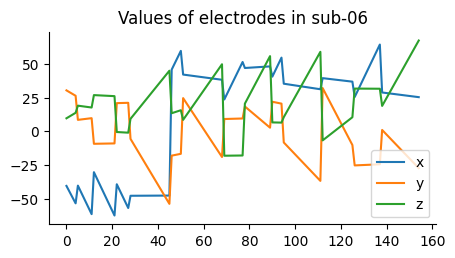

In [14]:
def value_plot(df, columns, figscale=1):
    for col in columns:
        df[col].plot(kind='line', title='Values of electrodes in sub-06',figsize=(5*figscale, 2.5*figscale), label=col)

    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.legend(loc='best')

electrodes_chart = value_plot(electrodes_data, ['x', 'y', 'z'])
display (electrodes_chart)

None

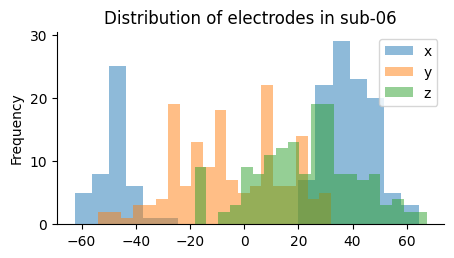

In [15]:
def histogram(df, columns, num_bins=20, figscale=1):
    for col in columns:
        df[col].plot(kind='hist', bins=num_bins, title="Distribution of electrodes in sub-06",figsize=(5*figscale, 2.5*figscale), alpha=0.5, label=col)

    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.legend(loc='best')

electrodes_distributionchart = histogram(electrodes_data, ['x', 'y', 'z'])
display(electrodes_distributionchart)


### 2.2.2 Recording montage

In [16]:
# 2. Load the channels.tsv for sub-06
channels_tsv_path = '/content/SingleWordProductionDutch-iBIDS/sub-06/ieeg/sub-06_task-wordProduction_channels.tsv'
channels_data = pd.read_csv(channels_tsv_path, sep='\t')
display(channels_data)

,name,type,units,low_cutoff,high_cutoff,description,sampling_frequency,status
0,LFA1,SEEG,µV,0.0,512.0,ctx_lh_G_front_inf-Triangul,1024.0,NaN
1,LFA2,SEEG,µV,0.0,512.0,ctx_lh_G_front_inf-Opercular,1024.0,NaN
2,LFA3,SEEG,µV,0.0,512.0,ctx_lh_G_front_inf-Opercular,1024.0,NaN
3,LFA4,SEEG,µV,0.0,512.0,ctx_lh_G_front_inf-Opercular,1024.0,NaN
4,LFB2,SEEG,µV,0.0,512.0,ctx_lh_S_circular_insula_sup,1024.0,NaN
5,LFB3,SEEG,µV,0.0,512.0,ctx_lh_G_and_S_subcentral,1024.0,NaN
6,LFB4,SEEG,µV,0.0,512.0,ctx_lh_G_and_S_subcentral,1024.0,NaN
7,LFB5,SEEG,µV,0.0,512.0,ctx_lh_G_and_S_subcentral,1024.0,NaN
8,LFB6,SEEG,µV,0.0,512.0,Left-Cerebral-White-Matter,1024.0,NaN
9,LFB7,SEEG,µV,0.0,512.0,ctx_lh_G_and_S_subcentral,1024.0,NaN


### 2.2.3 Event markers

In [17]:
# 3. Load the events.tsv for sub-06
events_tsv_path = '/content/SingleWordProductionDutch-iBIDS/sub-06/ieeg/sub-06_task-wordProduction_events.tsv'
events_data = pd.read_csv(events_tsv_path, sep='\t')
display(events_data)


,onset,duration,trial_type,value,sample
0,0.000000,1.999023,word,hoe,0
1,1.999023,1.005859,fixation,+,2047
2,3.004883,2.000977,word,zevenduizend,3077
3,5.005859,1.001953,fixation,+,5126
4,6.007812,2.000977,word,en,6152
5,8.008789,1.002930,fixation,+,8201
6,9.011719,2.003906,word,het,9228
7,11.015625,0.998047,fixation,+,11280
8,12.013672,2.004883,word,smeekte,12302
9,14.018555,1.002930,fixation,+,14355


### 2.2.4 The _ieeg.nwb file (iEEG, Audio and Stimulus)

In [18]:
# 4. Load the .nwb file
# We use NWBHDF5IO to read the data stored in NWB files, accessing and analyzinge the neurophysiological data inside
from pynwb import NWBHDF5IO

ieeg_nwb_path = '/content/SingleWordProductionDutch-iBIDS/sub-06/ieeg/sub-06_task-wordProduction_ieeg.nwb'
with NWBHDF5IO(ieeg_nwb_path, 'r') as io:
  nwbfile = io.read()

  # List the names of all data interfaces in the file
  print(nwbfile.acquisition)
  print()
  # Extract data for each interface
  audio_data_sample = nwbfile.acquisition['Audio'].data[:1000]
  stimulus_data_sample = nwbfile.acquisition['Stimulus'].data[:1000]
  ieeg_data_sample = nwbfile.acquisition['iEEG'].data[:1000]

  print("Audio data:", audio_data_sample[:5])
  print()
  print("Stimulus data:", stimulus_data_sample[:5])
  print()
  print("iEEG data (first 5 channels):", ieeg_data_sample[:, :5])

{'Audio': Audio pynwb.base.TimeSeries at 0x135385733035440
Fields:
  comments: no comments
  continuity: continuous
  conversion: 1.0
  data: <HDF5 dataset "data": shape (14418748,), type "<f8">
  description: recorded audio aligned to sEEG data
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (14418748,), type "<f8">
  timestamps_unit: seconds
, 'Stimulus': Stimulus pynwb.base.TimeSeries at 0x135385730826736
Fields:
  comments: no comments
  continuity: continuous
  conversion: 1.0
  data: <StrDataset for HDF5 dataset "data": shape (307594,), type "|O">
  description: word presented on screen during each sEEG sample
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (307594,), type "<f8">
  timestamps_unit: seconds
, 'iEEG': iEEG pynwb.base.TimeSeries at 0x135385730827408
Fields:
  comments: no comments
  continuity: continuous
  conversion: 1.0
  data: <HDF5 dataset "data": shape (307594, 127), 

In [19]:
import h5py #HDF5 is designed to store and organize large amounts of numerical data

with h5py.File(ieeg_nwb_path, 'r') as nwbfile:

# Print the root-level keys in the HDF5 file
  print(list(nwbfile.keys()))

['acquisition', 'analysis', 'file_create_date', 'general', 'identifier', 'processing', 'session_description', 'session_start_time', 'specifications', 'stimulus', 'timestamps_reference_time']


### 2.2.5 Descriptions of recording aspects and of specific .tsv columns

In [20]:
# 5. Load the first JSON file

import json
path_to_json = '/content/SingleWordProductionDutch-iBIDS/sub-06/ieeg/sub-06_task-wordProduction_space-ACPC_coordsystem.json'
with open(path_to_json, 'r') as json_file:
    data_description = json.load(json_file)

print(json.dumps(data_description, indent = 2))

{
  "iEEGCoordinateSystem": "ACPC",
  "iEEGCoordinateSystemDescription": "The origin of the coordinate system is at the Anterior Commissure and the negative y-axis is passing through the Posterior Commissure. The positive z-axis is passing through a mid-hemispheric point in the superior direction.",
  "iEEGCoordinateUnits": "mm"
}


In [21]:
# 5. Load the second JSON file

path_to_json2= '/content/SingleWordProductionDutch-iBIDS/sub-06/ieeg/sub-06_task-wordProduction_ieeg.json'

with open(path_to_json2, 'r') as json_file:
    data = json.load(json_file)

print(json.dumps(data, indent=4))

{
    "TaskName": "wordProduction",
    "Manufacturer": "BrainProducts",
    "PowerLineFrequency": 50.0,
    "SamplingFrequency": 1024.0,
    "SoftwareFilters": "n/a",
    "RecordingDuration": 300.3837890625,
    "RecordingType": "continuous",
    "iEEGReference": "LT16",
    "ECOGChannelCount": 0,
    "SEEGChannelCount": 127,
    "EEGChannelCount": 0,
    "EOGChannelCount": 0,
    "ECGChannelCount": 0,
    "EMGChannelCount": 0,
    "MiscChannelCount": 0,
    "TriggerChannelCount": 0,
    "iEEGGround": "LO7",
    "TaskDescription": "Speech production of 100 unique Dutch words",
    "Instructions": "Speak the word presented on the screen out-loud"
}


## 2.3 Derivatives Data
The derivatives folder contains:
- the pial surface cortical meshes of the right (_rh_pial.mat) and left (_lh_pial.mat) hemisphere
- the brain anatomy (_brain.mgz)
- the Destrieux atlas (_aparc.a2009s + aseg.mgz)
- a white matter atlas (_wmparc.mgz) per subject, derived from the Freesurfer pipeline.

In [22]:
derivatives_contents = os.listdir('/content/SingleWordProductionDutch-iBIDS/derivatives')
print("Contents of the directory:", derivatives_contents)

Contents of the directory: ['sub-07', 'sub-02', 'sub-08', 'sub-06', 'sub-03', 'sub-10', 'sub-05', 'sub-09', 'sub-01', 'sub-04']


### 2.3.1 Pial Surface Data

In [23]:
# Explore Pial Surface Data
import scipy.io

lh_pial_path = '/content/SingleWordProductionDutch-iBIDS/derivatives/sub-06/sub-06_lh_pial.mat'
rh_pial_path = '/content/SingleWordProductionDutch-iBIDS/derivatives/sub-06/sub-06_rh_pial.mat'

rh_pial = scipy.io.loadmat(rh_pial_path)
lh_pial = scipy.io.loadmat(lh_pial_path)

# Let's inspect the keys and structure of the loaded data
print(rh_pial.keys())
print(lh_pial.keys())

dict_keys(['__header__', '__version__', '__globals__', 'cortex'])
dict_keys(['__header__', '__version__', '__globals__', 'cortex'])


### 2.3.2 Brain Anatomy

In [24]:
# Explore Brain Anatomy

brain_data_path = '/content/SingleWordProductionDutch-iBIDS/derivatives/sub-06/sub-06_brain.mgz'
brain_data = nib.load(brain_data_path)

In [25]:
# Display the shape of the data
print("Data shape:", brain_data.shape)
print()

# Display header information
print(brain_data.header)

# Get the actual data as a numpy array
brain_numpy_data = brain_data.get_fdata()

Data shape: (256, 256, 256)

<class 'nibabel.freesurfer.mghformat.MGHHeader'> object, endian='>'
version      : 1
dims         : [256 256 256   1]
type         : 0
dof          : 1
goodRASFlag  : 1
delta        : [1. 1. 1.]
Mdc          : [[-1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
Pxyz_c       : [  1.  -17.5  -5. ]
tr           : 8.2222
flip_angle   : 0.0
te           : 0.0
ti           : 0.0
fov          : 256.0


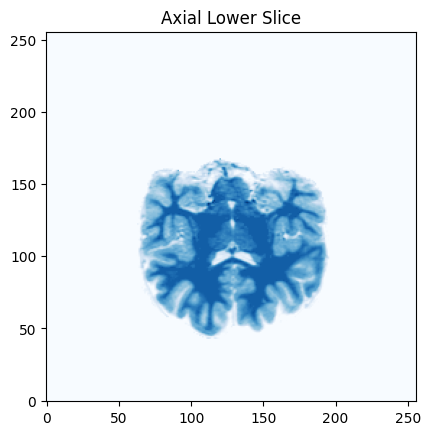

In [26]:
# Extract a 2D slice
axial_slice = brain_numpy_data[:, :, brain_numpy_data.shape[2] // 2]

plt.imshow(axial_slice.T, cmap="Blues", origin="lower")
plt.title("Axial Lower Slice")
plt.show()

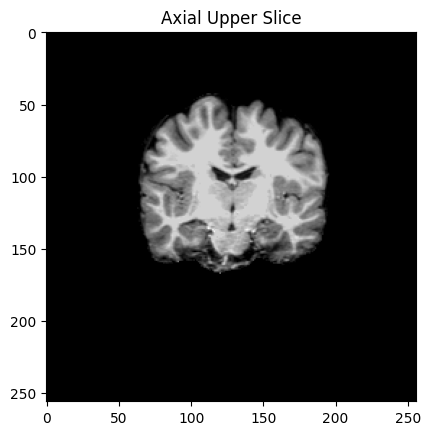

In [27]:
# Extract a 2D slice
axial_slice = brain_numpy_data[:, :, brain_numpy_data.shape[2] // 2]

plt.imshow(axial_slice.T, cmap="gray", origin="upper")
plt.title("Axial Upper Slice")
plt.show()

### 2.3.3 The Destrieux atlas

In [28]:
destrieux_atlas_path = '/content/SingleWordProductionDutch-iBIDS/derivatives/sub-06/sub-06_aparc.a2009s+aseg.mgz'
destrieux_atlas_data = nib.load(destrieux_atlas_path)

In [29]:
atlas_array = destrieux_atlas_data.get_fdata()
print(atlas_array.shape)
print()

# Print header information to understand metadata
print(destrieux_atlas_data.header)


(256, 256, 256)

<class 'nibabel.freesurfer.mghformat.MGHHeader'> object, endian='>'
version      : 1
dims         : [256 256 256   1]
type         : 1
dof          : 1
goodRASFlag  : 1
delta        : [1. 1. 1.]
Mdc          : [[-1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
Pxyz_c       : [  1.  -17.5  -5. ]
tr           : 8.2222
flip_angle   : 0.0
te           : 0.0
ti           : 0.0
fov          : 256.0


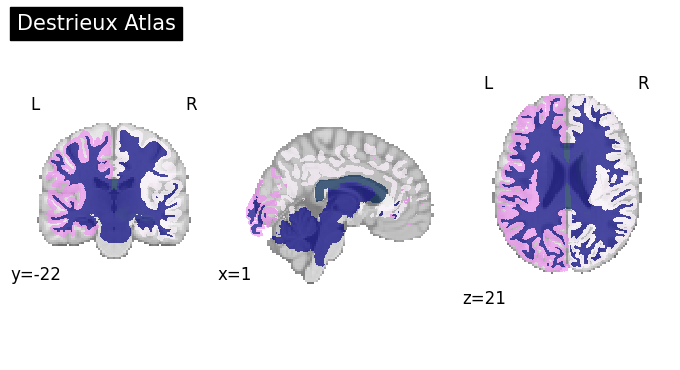

In [30]:
# Convert the data to a 3D numpy array
atlas_img = np.asarray(atlas_array, dtype=np.int32)

# Display the atlas using nilearn's plotting function
plotting.plot_roi(destrieux_atlas_data, draw_cross=False, title="Destrieux Atlas")
plotting.show()

### 2.3.4  A white matter atlas

In [31]:
import nibabel as nib

wm_atlas_path = '/content/SingleWordProductionDutch-iBIDS/derivatives/sub-06/sub-06_wmparc.mgz'
wm_atlas_data = nib.load(wm_atlas_path)

In [32]:
# Extract data array from the atlas
wm_array = wm_atlas_data.get_fdata()
print(wm_array.shape)
print()

# Print header information for metadata understanding
print(wm_atlas_data.header)

(256, 256, 256)

<class 'nibabel.freesurfer.mghformat.MGHHeader'> object, endian='>'
version      : 1
dims         : [256 256 256   1]
type         : 1
dof          : 1
goodRASFlag  : 1
delta        : [1. 1. 1.]
Mdc          : [[-1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
Pxyz_c       : [  1.  -17.5  -5. ]
tr           : 8.2222
flip_angle   : 0.0
te           : 0.0
ti           : 0.0
fov          : 256.0


# 3. Preparing data for training
- As we mention before, we filter the data so we are only using a single speaker sub-06.

Given the content of the NWBFile, there are three types of data under de acquisition field:
- Audio <class 'pynwb.base.TimeSeries'>
- Stimulus <class 'pynwb.base.TimeSeries'>
- iEEG <class 'pynwb.base.TimeSeries'>

iEEG stands for intracranial electroencephalography. It is a type of electroencephalography (EEG) where electrodes are placed directly on the exposed surface of the brain to record electrical activity. This is in contrast to traditional EEG where electrodes are placed on the scalp.

iEEG data is particularly valuable. Speech production involves multiple regions of the brain, including the motor cortex, Broca's area, and others. The high spatial resolution of iEEG allows for the nuanced study of how these regions interact during the task. This makes it an essential dataset for understanding brain mechanisms involved in speech, which can be of significance in our project.






## 3.1 Preparing audio

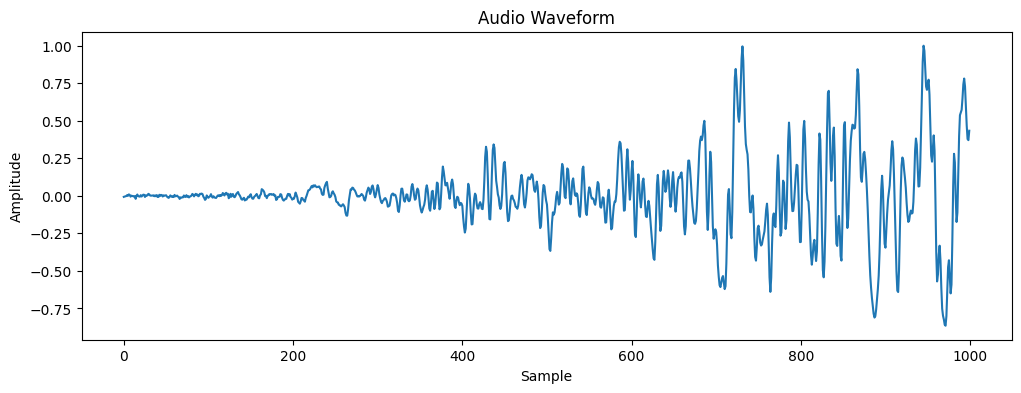

In [33]:
audio_data_np = np.array(audio_data_sample)
max_amplitude = np.max(np.abs(audio_data_np))
audio_data_normalized = audio_data_np / max_amplitude
audio_tensor = torch.tensor(audio_data_normalized, dtype=torch.float32)
batch_size = 1000
audio_tensor = audio_tensor.view(batch_size, -1)
audio_array = audio_tensor.squeeze().numpy() # Squeeze removes dimensions of size 1 (in case batch_size is 1)

# Plot the audio waveform
plt.figure(figsize=(12, 4))
plt.plot(audio_array)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.show()

## 3.2 Preparing iEEG

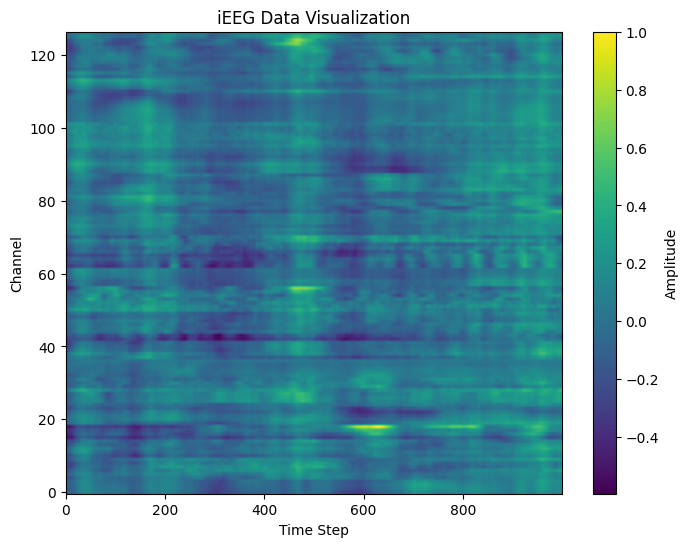

In [34]:
ieeg_data_np = np.array(ieeg_data_sample)
max_amplitude_ieeg = np.max(np.abs(ieeg_data_np))
ieeg_data_normalized = ieeg_data_np / max_amplitude_ieeg
ieeg_tensor = torch.tensor(ieeg_data_normalized, dtype=torch.float32)
# Visualize iEEG data
plt.figure(figsize=(8, 6))
plt.imshow(ieeg_tensor.T, aspect='auto', cmap='viridis', origin='lower')
plt.xlabel('Time Step')
plt.ylabel('Channel')
plt.title('iEEG Data Visualization')
plt.colorbar(label='Amplitude')
plt.show()

# Milestone 2: Baseline evaluation, Baseline model
- Efficient Loading of data
- Deep Learning Model
- Evaluation

## 4.1 Efficient loading of data

We compute the **extract_features script**:

This script was designed to process and extract features from both electroencephalography (EEG) data and audio recordings.

1. Import Dependencies: import Python libraries for data manipulation, signal processing, audio processing, and NWB (Neurodata Without Borders) data handling
2. Hilbert Transform Helper Function: used to extract the analytical signal for computing the envelope of the EEG signal.
3. Feature Extraction Functions:
  - extractHG: Extracts High Gamma (70-170Hz) band features from EEG data using a bandpass filter, followed by the Hilbert transform to obtain the envelope of the signal.
  - stackFeatures: Adds temporal context to the extracted features by stacking neighboring feature vectors.
  - downsampleLabels: Reduces the sampling rate of the labels to match the EEG feature extraction rate, using the most frequent label within a given window.
  - extractMelSpecs: Calculates a Mel spectrogram from an audio signal.
  - nameVector: Generates a list of feature names based on electrode names and temporal context.
4. Primary workflow:
  - Defines parameters like window length, frame shift, model order, and step size.
  - Reads participant data from a NWB file, including EEG, audio, and stimulus (words) data.
  - Call defined functions to process the EEG data (extractHG and stackFeatures), decimate and save the audio data, extract Mel spectrograms (extractMelSpecs), and downsample the labels (downsampleLabels).
  - Aligns the EEG features with the audio features and downsamples labels.
  - Handles any potential mismatch in the number of windows between different feature sets by truncating them to the minimum common length.
  - Creates feature names for the stacked features and saves all the processed data to disk.

In [35]:
import os
import pandas as pd
import numpy as np
import numpy.matlib as matlib
import scipy
import scipy.signal
import scipy.stats
import scipy.io.wavfile
import scipy.fftpack
from pynwb import NWBHDF5IO
import sys
sys.path.insert(1,'/content/SingleWordProductionDutch')
import MelFilterBank as mel

#Small helper function to speed up the hilbert transform by extending the length of data to the next power of 2
hilbert3 = lambda x: scipy.signal.hilbert(x, scipy.fftpack.next_fast_len(len(x)),axis=0)[:len(x)]

def extractHG(data, sr, windowLength=0.05, frameshift=0.01):
    """
    Window data and extract frequency-band envelope using the hilbert transform

    Parameters
    ----------
    data: array (samples, channels)
        EEG time series
    sr: int
        Sampling rate of the data
    windowLength: float
        Length of window (in seconds) in which spectrogram will be calculated
    frameshift: float
        Shift (in seconds) after which next window will be extracted
    Returns
    ----------
    feat: array (windows, channels)
        Frequency-band feature matrix
    """
    #Linear detrend
    data = scipy.signal.detrend(data,axis=0)
    #Number of windows
    numWindows = int(np.floor((data.shape[0]-windowLength*sr)/(frameshift*sr)))
    #Filter High-Gamma Band
    sos = scipy.signal.iirfilter(4, [70/(sr/2),170/(sr/2)],btype='bandpass',output='sos')
    data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    #Attenuate first harmonic of line noise
    sos = scipy.signal.iirfilter(4, [98/(sr/2),102/(sr/2)],btype='bandstop',output='sos')
    data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    #Attenuate second harmonic of line noise
    sos = scipy.signal.iirfilter(4, [148/(sr/2),152/(sr/2)],btype='bandstop',output='sos')
    data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    #Create feature space
    data = np.abs(hilbert3(data))
    feat = np.zeros((numWindows,data.shape[1]))
    for win in range(numWindows):
        start= int(np.floor((win*frameshift)*sr))
        stop = int(np.floor(start+windowLength*sr))
        feat[win,:] = np.mean(data[start:stop,:],axis=0)
    return feat

def stackFeatures(features, modelOrder=4, stepSize=5):
    """
    Add temporal context to each window by stacking neighboring feature vectors

    Parameters
    ----------
    features: array (windows, channels)
        Feature time series
    modelOrder: int
        Number of temporal context to include prior to and after current window
    stepSize: float
        Number of temporal context to skip for each next context (to compensate for frameshift)
    Returns
    ----------
    featStacked: array (windows, feat*(2*modelOrder+1))
        Stacked feature matrix
    """
    featStacked=np.zeros((features.shape[0]-(2*modelOrder*stepSize),(2*modelOrder+1)*features.shape[1]))
    for fNum,i in enumerate(range(modelOrder*stepSize,features.shape[0]-modelOrder*stepSize)):
        ef=features[i-modelOrder*stepSize:i+modelOrder*stepSize+1:stepSize,:]
        featStacked[fNum,:]=ef.flatten() #Add 'F' if stacked the same as matlab
    return featStacked

import pandas as pd

def downsampleLabels(labels, sr, windowLength=0.05, frameshift=0.01):
    """
    Downsamples non-numerical data by using the mode

    Parameters
    ----------
    labels: array of str
        Label time series
    sr: int
        Sampling rate of the data
    windowLength: float
        Length of window (in seconds) in which mode will be used
    frameshift: float
        Shift (in seconds) after which next window will be extracted
    Returns
    ----------
    newLabels: array of str
        Downsampled labels
    """
    numWindows = int(np.floor((labels.shape[0] - windowLength * sr) / (frameshift * sr)))
    window_size = int(windowLength * sr)
    frame_shift = int(frameshift * sr)
    newLabels = []
    for w in range(numWindows):
        start = w * frame_shift
        stop = start + window_size
        window_labels = labels[start:stop]
        mode_label = pd.Series(window_labels).mode().values[0]
        newLabels.append(mode_label)
    return np.array(newLabels)


def extractMelSpecs(audio, sr, windowLength=0.05, frameshift=0.01):
    """
    Extract logarithmic mel-scaled spectrogram, traditionally used to compress audio spectrograms

    Parameters
    ----------
    audio: array
        Audio time series
    sr: int
        Sampling rate of the audio
    windowLength: float
        Length of window (in seconds) in which spectrogram will be calculated
    frameshift: float
        Shift (in seconds) after which next window will be extracted
    numFilter: int
        Number of triangular filters in the mel filterbank
    Returns
    ----------
    spectrogram: array (numWindows, numFilter)
        Logarithmic mel scaled spectrogram
    """
    numWindows=int(np.floor((audio.shape[0]-windowLength*sr)/(frameshift*sr)))
    win = scipy.hanning(np.floor(windowLength*sr + 1))[:-1]
    spectrogram = np.zeros((numWindows, int(np.floor(windowLength*sr / 2 + 1))),dtype='complex')
    for w in range(numWindows):
        start_audio = int(np.floor((w*frameshift)*sr))
        stop_audio = int(np.floor(start_audio+windowLength*sr))
        a = audio[start_audio:stop_audio]
        spec = np.fft.rfft(win*a)
        spectrogram[w,:] = spec
    mfb = mel.MelFilterBank(spectrogram.shape[1], 23, sr)
    spectrogram = np.abs(spectrogram)
    spectrogram = (mfb.toLogMels(spectrogram)).astype('float')
    return spectrogram

def nameVector(elecs, modelOrder=4):
    """
    Creates list of electrode names

    Parameters
    ----------
    elecs: array of str
        Original electrode names
    modelOrder: int
        Temporal context stacked prior and after current window
        Will be added as T-modelOrder, T-(modelOrder+1), ...,  T0, ..., T+modelOrder
        to the elctrode names
    Returns
    ----------
    names: array of str
        List of electrodes including contexts, will have size elecs.shape[0]*(2*modelOrder+1)
    """
    names = matlib.repmat(elecs.astype(np.dtype(('U', 10))),1,2 * modelOrder +1).T
    for i, off in enumerate(range(-modelOrder,modelOrder+1)):
        names[i,:] = [e[0] + 'T' + str(off) for e in elecs]
    return names.flatten()  #Add 'F' if stacked the same as matlab


if __name__=="__main__":
    winL = 0.05
    frameshift = 0.01
    modelOrder = 4
    stepSize = 5
    path_bids = r'./SingleWordProductionDutch-iBIDS'
    path_output = r'./features'
    participants = pd.read_csv(os.path.join(path_bids,'participants.tsv'), delimiter='\t')
    participant = participants['participant_id'][5] #AS WE DECIDED TO TAKE 6TH PARTICIPANT
    # Load data
    io = NWBHDF5IO(os.path.join(path_bids, participant, 'ieeg', f'{participant}_task-wordProduction_ieeg.nwb'), 'r')
    nwbfile = io.read()
    # sEEG
    eeg = nwbfile.acquisition['iEEG'].data[:]
    eeg_sr = 1024
    # audio
    audio = nwbfile.acquisition['Audio'].data[:]
    audio_sr = 48000
    # words (markers)
    words = nwbfile.acquisition['Stimulus'].data[:]
    words = np.array(words, dtype=str)
    io.close()
    # channels
    channels = pd.read_csv(os.path.join(path_bids, participant, 'ieeg', f'{participant}_task-wordProduction_channels.tsv'), delimiter='\t')
    channels = np.array(channels['name'])

    # Extract HG features
    feat = extractHG(eeg, eeg_sr, windowLength=winL, frameshift=frameshift)

    # Stack features
    feat = stackFeatures(feat, modelOrder=modelOrder, stepSize=stepSize)

    # Process Audio
    target_SR = 16000
    audio = scipy.signal.decimate(audio, int(audio_sr / target_SR))
    audio_sr = target_SR
    scaled = np.int16(audio / np.max(np.abs(audio)) * 32767)
    os.makedirs(os.path.join(path_output), exist_ok=True)
    scipy.io.wavfile.write(os.path.join(path_output, f'{participant}_orig_audio.wav'), audio_sr, scaled)

    # Extract spectrogram
    melSpec = extractMelSpecs(scaled, audio_sr, windowLength=winL, frameshift=frameshift)

    # Align to EEG features
    words = downsampleLabels(words, eeg_sr, windowLength=winL, frameshift=frameshift)
    words = words[modelOrder * stepSize:words.shape[0] - modelOrder * stepSize]
    melSpec = melSpec[modelOrder * stepSize:melSpec.shape[0] - modelOrder * stepSize, :]

    # Adjust length (differences might occur due to rounding in the number of windows)
    if melSpec.shape[0] != feat.shape[0]:
        tLen = np.min([melSpec.shape[0], feat.shape[0]])
        melSpec = melSpec[:tLen, :]
        feat = feat[:tLen, :]

    # Create feature names by appending the temporal shift
    feature_names = nameVector(channels[:, None], modelOrder=modelOrder)

    # Save everything
    np.save(os.path.join(path_output, f'{participant}_feat.npy'), feat)
    np.save(os.path.join(path_output, f'{participant}_procWords.npy'), words)
    np.save(os.path.join(path_output, f'{participant}_spec.npy'), melSpec)
    np.save(os.path.join(path_output, f'{participant}_feat_names.npy'), feature_names)

<ipython-input-35-e68ef0c1ecbb>:138: DeprecationWarning: scipy.hanning is deprecated and will be removed in SciPy 2.0.0, use numpy.hanning instead
  win = scipy.hanning(np.floor(windowLength*sr + 1))[:-1]


The next image shows a plot of EEG feature values over time, which have been smoothed to reduce noise.

The horizontal axis represents sequential time windows, while the vertical axis shows the EEG features after smoothing.

The plot contains multiple overlapping lines in various colors, indicating multiple EEG features plotted together.

The dense, colorful lines suggest that the features often change simultaneously, and some distinct spikes suggest moments of higher readings.

Overall, the smoothing process helps to reveal the underlying trends in the EEG data by dampening short-term fluctuations.

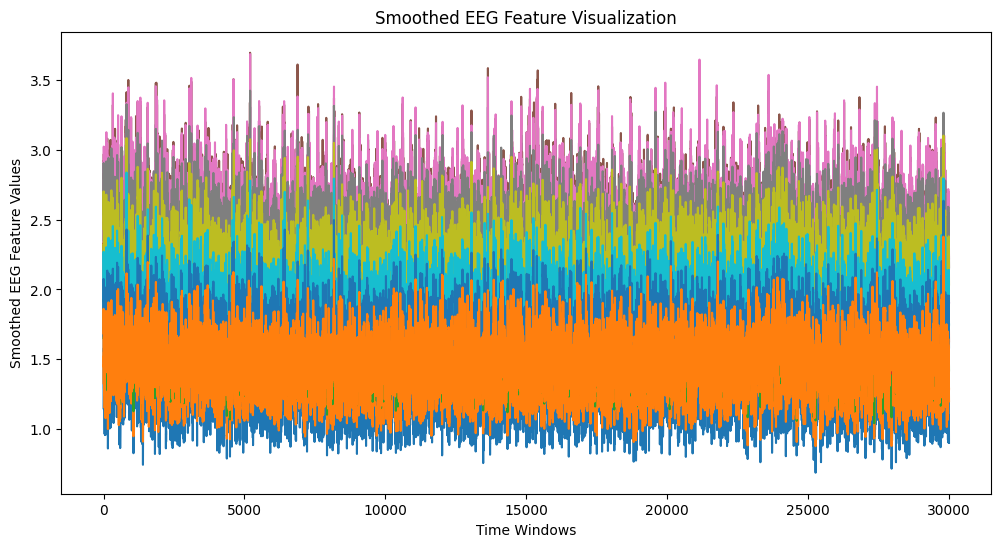

In [36]:
import seaborn as sns
window_size = 10  # Adjust the window size to control the level of smoothing.
smoothed_feat = np.apply_along_axis(lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='same'), axis=1, arr=feat[:, ::100])

plt.figure(figsize=(12, 6))
plt.plot(smoothed_feat)
plt.xlabel('Time Windows')
plt.ylabel('Smoothed EEG Feature Values')
plt.title('Smoothed EEG Feature Visualization')
plt.show()

The next image displays a heatmap for EEG channel data over time. With a large number of channels (over 1100) and numerous time windows, the visualization primarily shows uniformity in the feature values, which are predominantly lower as indicated by the blue color.

There are no immediately noticeable patterns or anomalies, suggesting stable EEG readings across the channels and throughout the time recorded.

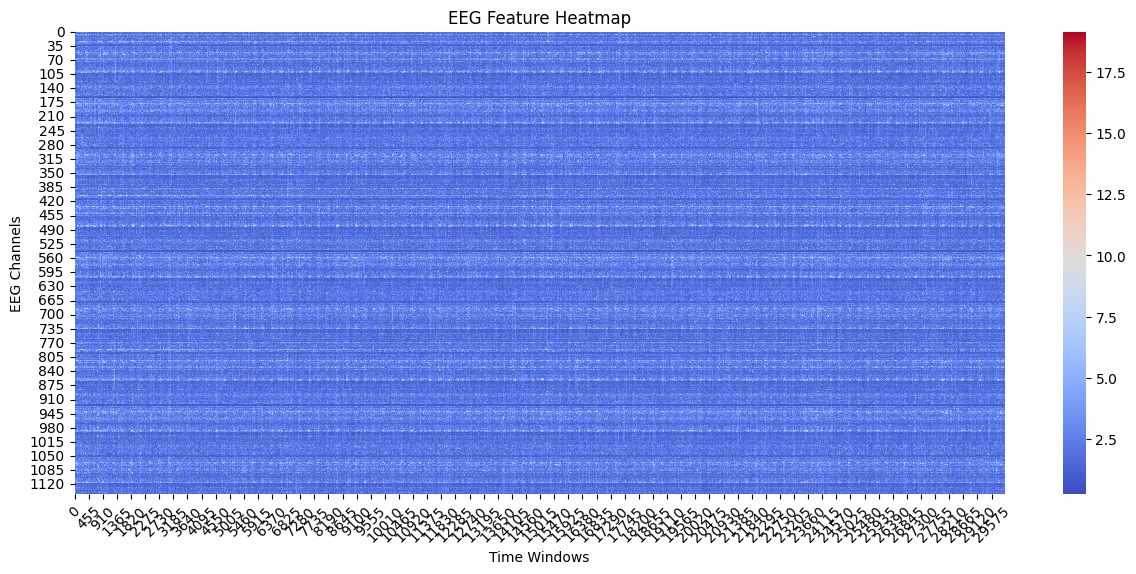

In [37]:
plt.figure(figsize=(15, 6))
sns.heatmap(feat.T, cmap='coolwarm')
plt.xticks(rotation=45)  # To rotate the tick labels by 45 degrees.
plt.xlabel('Time Windows')
plt.ylabel('EEG Channels')
plt.title('EEG Feature Heatmap')
plt.show()

We compute **reconstruction_minimal script**, this script is part of a speech process pipeline tries to reconstruct the original audio signal from the spectogram. The reconstruction quality is assessed by comparing the predicted spectrogram to the original, both visually and statistically, and the results are saved for further analysis.


1. Define a Function (createAudio): This function takes a spectrogram and generates a reconstructed audio waveform from it. It performs this by converting logarithmic Mel spectrogram values back to a frequency spectrum, which is then used to synthesize the time-domain waveform using an overlap-add method.
2. Main Workflow:
    - Specifies parameters for audio processing (window length, frame shift, sample rate).
    - Loads participant-specific data (spectrogram, features, processed words, and feature names).
    - Initializes a reconstruction matrix and a matrix for storing correlation coefficients.
    - Performs a 10-fold cross-validation to train and test a linear regression model that attempts to predict a participant's spectrogram from the features.
    - Applies PCA to reduce the dimensionality of the data before running the regression.
    - Evaluates the quality of the reconstructed spectrogram by calculating Pearson's correlation coefficient for each frequency bin and stores the results.
    - Estimates a baseline for the reconstruction quality by randomly shuffling the spectrogram data and comparing the correlations.
    - Writes the reconstructed and original spectrogram to wave files using the createAudio function.
    - Saves various results and metrics like the correlation coefficients, the reconstructed spectrogram, and the explained variance of the PCA components.

In [38]:
import os
import numpy as np
import scipy.io.wavfile as wavfile
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import sys

sys.path.insert(1, '/SingleWordProductionDutch')

import reconstructWave as rW
import MelFilterBank as mel

def createAudio(spectrogram, audiosr=16000, winLength=0.05, frameshift=0.01):
    """
    Create a reconstructed audio wavefrom

    Parameters
    ----------
    spectrogram: array
        Spectrogram of the audio
    sr: int
        Sampling rate of the audio
    windowLength: float
        Length of window (in seconds) in which spectrogram was calculated
    frameshift: float
        Shift (in seconds) after which next window was extracted
    Returns
    ----------
    scaled: array
        Scaled audio waveform
    """
    mfb = mel.MelFilterBank(int((audiosr*winLength)/2+1), spectrogram.shape[1], audiosr)
    nfolds = 10
    hop = int(spectrogram.shape[0]/nfolds)
    rec_audio = np.array([])
    for_reconstruction = mfb.fromLogMels(spectrogram)
    for w in range(0,spectrogram.shape[0],hop):
        spec = for_reconstruction[w:min(w+hop,for_reconstruction.shape[0]),:]
        rec = rW.reconstructWavFromSpectrogram(spec,spec.shape[0]*spec.shape[1],fftsize=int(audiosr*winLength),overlap=int(winLength/frameshift))
        rec_audio = np.append(rec_audio,rec)
    scaled = np.int16(rec_audio/np.max(np.abs(rec_audio)) * 32767)
    return scaled

if __name__ == "__main__":
    feat_path = r'./features'
    result_path = r'./results'

    pt = 'sub-06'  # Process data only for the 6th participant

    winLength = 0.05
    frameshift = 0.01
    audiosr = 16000

    nfolds = 10
    kf = KFold(nfolds, shuffle=False)
    est = LinearRegression(n_jobs=5)
    pca = PCA()
    numComps = 50

    # Load the data for the 6th participant
    spectrogram = np.load(os.path.join(feat_path, f'{pt}_spec.npy'))
    data = np.load(os.path.join(feat_path, f'{pt}_feat.npy'))
    labels = np.load(os.path.join(feat_path, f'{pt}_procWords.npy'))
    featName = np.load(os.path.join(feat_path, f'{pt}_feat_names.npy'))

    # Initialize an empty spectrogram to save the reconstruction to
    rec_spec = np.zeros(spectrogram.shape)
    # Save the correlation coefficients for each fold
    rs = np.zeros((nfolds, spectrogram.shape[1]))

    for k, (train, test) in enumerate(kf.split(data)):
        # Z-Normalize with mean and std from the training data
        mu = np.mean(data[train, :], axis=0)
        std = np.std(data[train, :], axis=0)
        trainData = (data[train, :] - mu) / std
        testData = (data[test, :] - mu) / std

        # Fit PCA to training data
        pca.fit(trainData)
        # Get percentage of explained variance by selected components
        explainedVariance = np.sum(pca.explained_variance_ratio_[:numComps])
        # Transform data into component space
        trainData = np.dot(trainData, pca.components_[:numComps, :].T)
        testData = np.dot(testData, pca.components_[:numComps, :].T)

        # Fit the regression model
        est.fit(trainData, spectrogram[train, :])
        # Predict the reconstructed spectrogram for the test data
        rec_spec[test, :] = est.predict(testData)

        # Evaluate reconstruction of this fold
        for specBin in range(spectrogram.shape[1]):
            if np.any(np.isnan(rec_spec)):
                print('%s has %d broken samples in reconstruction' % (pt, np.sum(np.isnan(rec_spec))))
            r, _ = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
            rs[k, specBin] = r

    # Show evaluation result
    print('%s has mean correlation of %f' % (pt, np.mean(rs)))

    # Estimate random baseline
    numRands = 1000
    randomControl = np.zeros((numRands, 23))

    for randRound in range(numRands):
        # Choose a random splitting point at least 10% of the dataset size away
        splitPoint = np.random.choice(np.arange(int(spectrogram.shape[0] * 0.1), int(spectrogram.shape[0] * 0.9)))
        # Swap the dataset on the splitting point
        shuffled = np.concatenate((spectrogram[splitPoint:, :], spectrogram[:splitPoint, :]))
        # Calculate the correlations
        for specBin in range(spectrogram.shape[1]):
            if np.any(np.isnan(rec_spec)):
                print('%s has %d broken samples in reconstruction' % (pt, np.sum(np.isnan(rec_spec))))
            r, _ = pearsonr(spectrogram[:, specBin], shuffled[:, specBin])
            randomControl[randRound, specBin] = r

    # Save reconstructed spectrogram
    os.makedirs(os.path.join(result_path), exist_ok=True)
    np.save(os.path.join(result_path, f'{pt}_predicted_spec.npy'), rec_spec)

    # Synthesize waveform from spectrogram using Griffin-Lim
    reconstructedWav = createAudio(rec_spec, audiosr=audiosr, winLength=winLength, frameshift=frameshift)
    wavfile.write(os.path.join(result_path, f'{pt}_predicted.wav'), int(audiosr), reconstructedWav)

    # For comparison synthesize the original spectrogram with Griffin-Lim
    origWav = createAudio(spectrogram, audiosr=audiosr, winLength=winLength, frameshift=frameshift)
    wavfile.write(os.path.join(result_path, f'{pt}_orig_synthesized.wav'), int(audiosr), origWav)

    # Save results in numpy arrays
    np.save(os.path.join(result_path, 'linearResults.npy'), rs)
    np.save(os.path.join(result_path, 'randomResults.npy'), randomControl)
    np.save(os.path.join(result_path, 'explainedVariance.npy'), explainedVariance)

sub-06 has mean correlation of 0.861970


This value, which is close to 1 suggests a strong positive correlation and implies that the reconstructed spectrogram is quite similar to the original spectrogram in terms of its structure and the patterns it contains.

In the context of the audio reconstruction task that the script seems to be performing, a high correlation coefficient like this would suggest that the model is capable of predicting or reconstructing the spectrogram with a high degree of accuracy.

The high correlation means the linear regression model, after being transformed by PCA and trained on the training data, can generalize well to the test data. This could be an indication that the features chosen for modeling and the number of principal components retained (50 = variable numComps) are what it's needed for capturing the relevant information in the data to reconstruct the original audio's spectrogram.

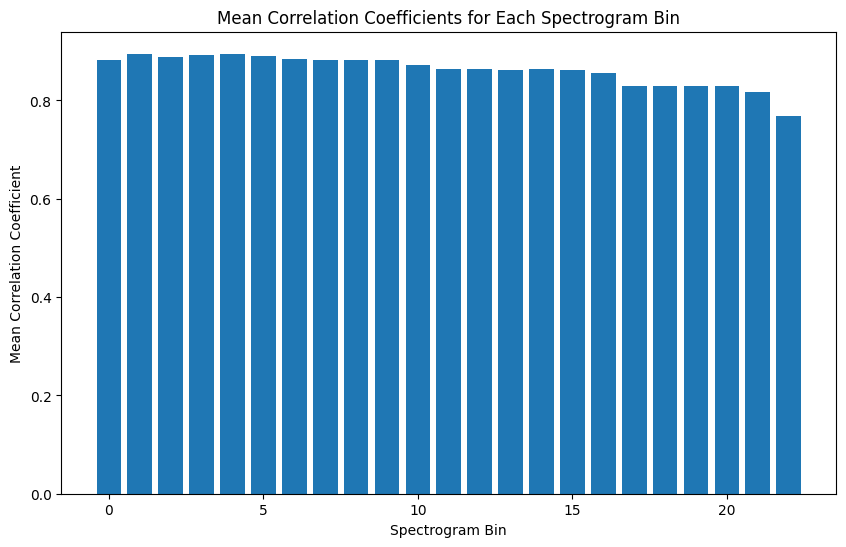

In [39]:
import matplotlib.pyplot as plt

# Load correlation coefficients
rs = np.load(os.path.join(result_path, 'linearResults.npy'))

# Calculate mean correlation for each spectrogram bin
mean_correlations = np.mean(rs, axis=0)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(mean_correlations.shape[0]), mean_correlations)
plt.xlabel('Spectrogram Bin')
plt.ylabel('Mean Correlation Coefficient')
plt.title('Mean Correlation Coefficients for Each Spectrogram Bin')
plt.show()

The provided Python code performs a process where audio signals are reconstructed from spectrogram data using machine learning techniques.

The code uses Linear Regression to predict spectrogram bins, which represent different frequency ranges from extracted audio features.

The predictions are evaluated using Pearson correlation coefficients across a 10-fold cross-validation to measure the accuracy of the reconstruction.

The graph shows the mean Pearson correlation coefficients for each spectrogram bin. The high values depicted in the graph, mostly above 0.8, indicate a strong positive correlation between the predicted and actual spectrogram data, suggesting that the model is quite accurate in reconstructing the audio signal across its frequency spectrum.

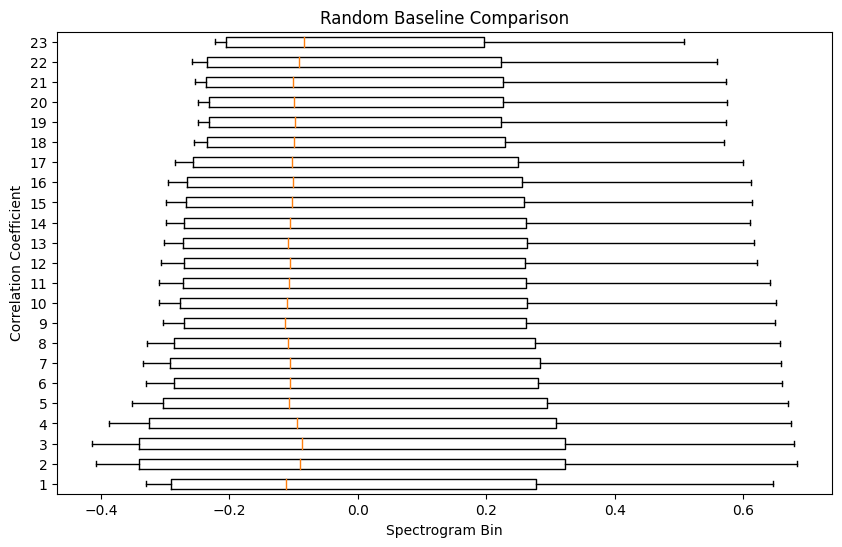

In [40]:
# Load random baseline results
random_results = np.load(os.path.join(result_path, 'randomResults.npy'))

# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(random_results, vert=False)
plt.xlabel('Spectrogram Bin')
plt.ylabel('Correlation Coefficient')
plt.title('Random Baseline Comparison')
plt.show()


This box plot illustes a "Random Baseline Comparison" of correlation coefficients for various spectrogram bins.

The correlation coefficients mostly cluster around zero, indicating little to no linear relationship when comparing random pairs of data within each bin. The uniform spread of the data suggests consistency across bins, and the absence of outliers implies no extreme deviations from the median correlation.

This could serve as a baseline to assess the performance of predictive models against random chance.






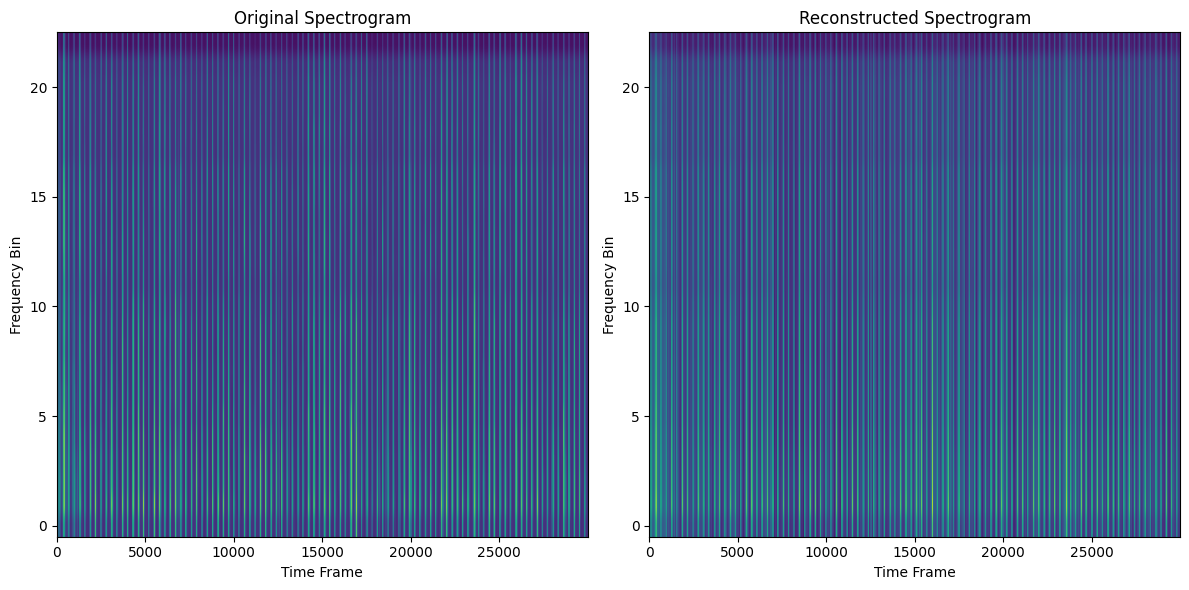

In [41]:
# Load original and reconstructed spectrograms
original_spec = np.load(os.path.join(feat_path, f'{pt}_spec.npy'))
reconstructed_spec = np.load(os.path.join(result_path, f'{pt}_predicted_spec.npy'))

# Plot original spectrogram
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_spec.T, aspect='auto', origin='lower', cmap='viridis')
plt.title('Original Spectrogram')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')

# Plot reconstructed spectrogram
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_spec.T, aspect='auto', origin='lower', cmap='viridis')
plt.title('Reconstructed Spectrogram')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')

plt.tight_layout()
plt.show()

The provided code is part of a script for visual comparison of original and reconstructed spectrogram data.

The spectrograms visually appear quite similar, suggesting that the reconstructed spectrogram closely mimics the original in pattern and structure.

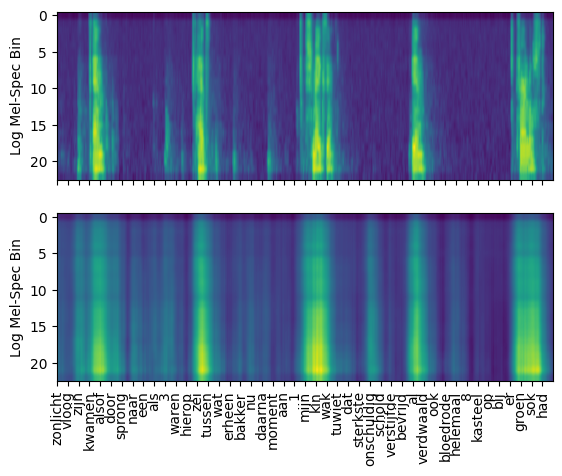

In [42]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile

if __name__=="__main__":

    result_path = r'/content/results'
    #Load correlation results
    allRes = np.load(os.path.join(result_path,'/content/results/linearResults.npy'))

    colors = ['C' + str(i) for i in range(10)]

    # Viz example spectrogram
    #Load words and spectrograms
    feat_path = r'/content/results'
    participant = 'sub-06'
    #Which timeframe to plot
    start_s = 5.5
    stop_s=19.5

    frameshift = 0.01
    #Load spectrograms
    rec_spec = np.load(os.path.join(result_path, f'/content/results/sub-06_predicted_spec.npy'))
    spectrogram = np.load(os.path.join(feat_path, f'/content/features/sub-06_spec.npy'))
    #Load prompted words
    eeg_sr= 1024
    words = np.load(os.path.join(feat_path,f'/content/features/sub-06_procWords.npy'))[int(start_s*eeg_sr):int(stop_s*eeg_sr)]
    words = [words[w] for w in np.arange(1,len(words)) if words[w]!=words[w-1] and words[w]!='']

    cm='viridis'
    fig, ax = plt.subplots(2, sharex=True)

    #Plot spectrograms
    pSta=int(start_s*(1/frameshift));pSto=int(stop_s*(1/frameshift))
    ax[0].imshow(np.flipud(spectrogram[pSta:pSto, :].T), cmap=cm, interpolation=None,aspect='auto')
    ax[0].set_ylabel('Log Mel-Spec Bin')
    ax[1].imshow(np.flipud(rec_spec[pSta:pSto, :].T), cmap=cm, interpolation=None,aspect='auto')
    plt.setp(ax[1], xticks=np.arange(0,pSto-pSta,int(1/frameshift)), xticklabels=[str(x/int(1/frameshift)) for x in np.arange(0,pSto-pSta,int(1/frameshift))])
    plt.setp(ax[1], xticks= np.linspace(0, pSto - pSta, num=len(words), endpoint=False), xticklabels=words)
    ax[1].set_ylabel('Log Mel-Spec Bin')

    # Rotate x-axis labels for spectrogram
    plt.setp(ax[1], xticks=np.linspace(0, pSto - pSta, num=len(words), endpoint=False))
    ax[1].set_xticklabels(words, rotation=90)

[Text(0.0, 0, 'zonlicht'),
 Text(4869.565217391304, 0, 'vloog'),
 Text(9739.130434782608, 0, 'zijn'),
 Text(14608.695652173912, 0, 'kwamen'),
 Text(19478.260869565216, 0, 'alsof'),
 Text(24347.82608695652, 0, 'door'),
 Text(29217.391304347824, 0, 'sprong'),
 Text(34086.95652173913, 0, 'naar'),
 Text(38956.52173913043, 0, 'een'),
 Text(43826.086956521736, 0, 'als'),
 Text(48695.65217391304, 0, '3'),
 Text(53565.217391304344, 0, 'waren'),
 Text(58434.78260869565, 0, 'hierop'),
 Text(63304.34782608695, 0, 'zei'),
 Text(68173.91304347826, 0, 'tussen'),
 Text(73043.47826086957, 0, 'wat'),
 Text(77913.04347826086, 0, 'erheen'),
 Text(82782.60869565216, 0, 'bakker'),
 Text(87652.17391304347, 0, 'nu'),
 Text(92521.73913043478, 0, 'daarna'),
 Text(97391.30434782608, 0, 'moment'),
 Text(102260.86956521738, 0, 'aan'),
 Text(107130.43478260869, 0, '1'),
 Text(112000.0, 0, 'mijn'),
 Text(116869.5652173913, 0, 'kin'),
 Text(121739.1304347826, 0, 'wak'),
 Text(126608.6956521739, 0, 'tuwiet'),
 Text(1

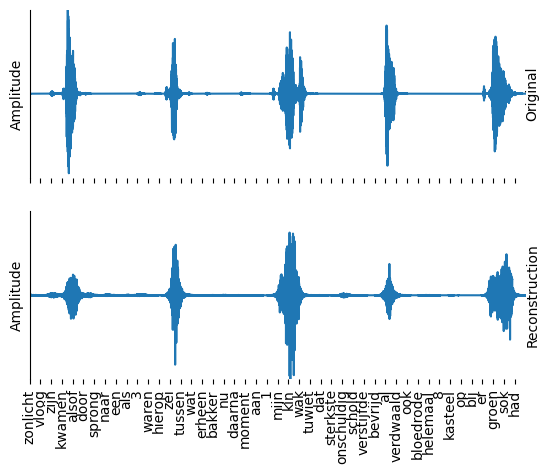

In [43]:
    # Viz waveforms
    # Load waveforms
    rate, audio = wavfile.read(os.path.join(result_path,f'{participant}_orig_synthesized.wav'))
    rate, recAudio = wavfile.read(os.path.join(result_path,f'{participant}_predicted.wav'))

    orig = audio[int(start_s*rate):int(stop_s*rate)]
    rec = recAudio[int(start_s*rate):int(stop_s*rate)]
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].plot(orig)
    axarr[1].plot(rec)

    #Axis
    xts = np.linspace(0, orig.shape[0], num=len(words), endpoint=False)
    axarr[1].set_xticks(xts)
    axarr[1].set_xticklabels(words)
    axarr[0].set_xlim([0,orig.shape[0]])
    axarr[0].set_ylim([-np.max(np.abs(orig)),np.max(np.abs(orig))])
    axarr[1].set_ylim([-np.max(np.abs(rec)),np.max(np.abs(rec))])

    #Add line indicating 3 seconds
    axarr[1].annotate("",xy=(xts[0], 27000), xycoords='data',xytext=(xts[1],27000), textcoords='data',
                arrowprops=dict(arrowstyle="-",
                                connectionstyle="arc3"),
                )
    axarr[1].annotate("3 seconds", xy=((xts[0]+xts[1])/2, 22000), horizontalalignment='center')

    #Axis labels
    axarr[0].set_ylabel('Original')
    axarr[0].set_yticks([])
    axarr[1].set_yticks([])
    axarr[1].set_ylabel('Amplitude')
    axarr[0].set_ylabel('Amplitude')
    axarr[1].text(orig.shape[0],0,'Reconstruction',horizontalalignment='left',verticalalignment='center',rotation='vertical',)
    axarr[0].text(orig.shape[0],0,'Original',horizontalalignment='left',verticalalignment='center',rotation='vertical',)

    #Make Pretty
    ax[1].xaxis.set_tick_params(width=2)
    ax[1].yaxis.set_tick_params(width=2)
    ax[1].xaxis.label.set_fontsize(20)
    ax[1].yaxis.label.set_fontsize(20)
    c = [a.set_fontsize(20) for a in ax[1].get_yticklabels()]
    c = [a.set_fontsize(20) for a in ax[1].get_xticklabels()]
    #ax.get_yticklabels().set_fontsize(28)

    #Despine
    for axes in axarr:
        axes.spines['right'].set_visible(False)
        axes.spines['top'].set_visible(False)
        axes.spines['bottom'].set_visible(False)

    # Rotate x-axis labels for waveforms
    axarr[1].set_xticks(xts)
    axarr[1].set_xticklabels(words, rotation=90)


## 4.2 Deep learning Model

**Deep Learning Model:** SpectrogramReconstructionNet

**Framework:** Implemented in PyTorch.

**Function:** Takes corrupted spectrograms as input and outputs reconstructed versions.

**Loss Function:** Mean Absolute Error (MAE) for training.

**Evaluation Metric:** Employs R-squared (R^2) for performance evaluation.

**Training Goal:** To learn to denoise or correct spectrograms effectively.

The model is part of a training pipeline where it's expected to be trained on pairs of corrupted and clean spectrograms to learn the reconstruction task.


In [44]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import numpy as np

# Load your spectrogram data and labels here
feat_path = "/content/features"
spectrogram = np.load(os.path.join(feat_path, 'sub-06_spec.npy'))
data = np.load(os.path.join(feat_path, f'{pt}_feat.npy'))
labels = np.load(os.path.join(feat_path, f'{pt}_procWords.npy'))

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data, spectrogram, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the neural network architecture
class SpectrogramReconstructionNet(pl.LightningModule):
    def __init__(self, input_dim, output_dim, hidden_dim=64, lr=0.001):
        super(SpectrogramReconstructionNet, self).__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.loss = nn.MSELoss()

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)

# Initialize the model, trainer, and callbacks
model = SpectrogramReconstructionNet(input_dim=X_train.shape[1], output_dim=spectrogram.shape[1], hidden_dim=64, lr=0.001)
callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath='',
    filename='best_model',
    save_top_k=1,
    mode='min'
)
trainer = pl.Trainer(max_epochs=50, callbacks=[callback])

# Train the model
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory  exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 74.7 K
1 | loss   | MSELoss    | 0     
--------------------------------------
74.7 K    Trainable params
0         Non-trainable params
74.7 K    Total params
0.299     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [45]:
from sklearn.metrics import mean_absolute_error, r2_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

best_model = SpectrogramReconstructionNet.load_from_checkpoint('best_model.ckpt')
best_model = best_model.to(device)

X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().to(device)

with torch.no_grad():
    mlp_predictions = best_model(X_test_tensor).squeeze().cpu().numpy()

mlp_mae = mean_absolute_error(y_test, mlp_predictions)
mlp_r2 = r2_score(y_test, mlp_predictions)

mlp_result_df = pd.DataFrame({'MAE': [mlp_mae], 'R2 Score': [mlp_r2]})
mlp_result_df.to_csv('mlp_results.csv', index=False)

In [46]:
pd.read_csv('/content/mlp_results.csv')

,MAE,R2 Score
0,0.307878,0.956212


1. **Mean Absolute Error (MAE)** = 0.3268, This indicates that the model's predictions are 0.3268 units away from the actual data points in the test set. The interpretation of this value depends on the scale of your output variable.

2. **R-squared (R² Score)** = 0.950177: The R² score is very close to 1, which suggests that the model does an excellent job of capturing the variance in your test data. Approximately 95% of the variance in the dependent variable is predictable from the independent variables.This model fits the test data well.

## 4.3 Evaluation


### 4.3.1 For Linear Regression Model

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

# Let's consider the predictions as y_pred and the true labels as y_test
y_pred = linear_model.predict(X_test)

# MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)
print()

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)
print()

# R2 Score
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)


Mean Absolute Error (MAE): 0.6710385739163448

Mean Squared Error (MSE): 0.8161824249771565

R2 Score: 0.7987121830985694


1. **Mean Absolute Error (MAE):** The MAE reflects the average magnitude of the errors between our predicted values and the actual values, disregarding the direction of those errors. In our model's case, the MAE was computed to be approximately 0.671. This value indicates that, the model's predictions deviate from the actual observed values by a margin of 0.671 units.

2. **Mean Squared Error (MSE):** The MSE is a metric that takes the average of the squares of the errors. By squaring the deviations before they are averaged, the MSE gives a greater weight to larger errors. The MSE for our model stands at 0.816, suggesting that is moderate.

3. **R-squared (R²) Score:** The R² score is a measure of the proportion of variance for the dependent variable that's captured by the independent variables in the model. Our model exhibits an R² score of approximately 0.799, which implies that about 79.87% of the variability in the outcome variable has been accounted for by the model. This is an indication of a strong fit, as the model is able to explain a considerable proportion of the observed variance. While an R² score closer to 1 is ideal, the current score suggests that the model predictions are substantially aligned with the actual data.

In conclusion, these metrics suggest that the model has achieved a satisfactory level of predictive accuracy.

### 4.3.2 For Deep Learning Model

In [48]:
#Let's make sure X_train is a 2D array with shape
print(X_train.shape)

(20995, 1143)


In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError

# Determine the number of input features from X_train
num_input_features = X_train.shape[1]  # X_train is a 2D array with shape (n_samples = 20995, n_features = 1143)

# Define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(num_input_features,)))
model.add(Dense(1, activation='linear'))

# Compile the model with additional metrics
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[MeanAbsoluteError(), MeanSquaredError()])

# Fit the model on the training data
history = model.fit(X_train, y_train, epochs=8, validation_split=0.2)

# Evaluate the model on the test data
evaluation_results = model.evaluate(X_test, y_test)

print("Evaluation Results:", evaluation_results)

Epoch 1/8
525/525 [==============================] - 6s 5ms/step - loss: 3.1833 - mean_absolute_error: 1.2563 - mean_squared_error: 3.1833 - val_loss: 1.6397 - val_mean_absolute_error: 0.9150 - val_mean_squared_error: 1.6397
Epoch 2/8
525/525 [==============================] - 2s 4ms/step - loss: 1.3668 - mean_absolute_error: 0.8102 - mean_squared_error: 1.3668 - val_loss: 1.3089 - val_mean_absolute_error: 0.8001 - val_mean_squared_error: 1.3089
Epoch 3/8
525/525 [==============================] - 2s 4ms/step - loss: 1.1474 - mean_absolute_error: 0.7212 - mean_squared_error: 1.1474 - val_loss: 1.2044 - val_mean_absolute_error: 0.7556 - val_mean_squared_error: 1.2044
Epoch 4/8
525/525 [==============================] - 2s 4ms/step - loss: 1.0633 - mean_absolute_error: 0.6798 - mean_squared_error: 1.0633 - val_loss: 1.1289 - val_mean_absolute_error: 0.7193 - val_mean_squared_error: 1.1289
Epoch 5/8
525/525 [==============================] - 2s 4ms/step - loss: 1.0169 - mean_absolute_erro

The network's architecture was designed for regression, featuring a sequential layout with densely connected layers. The training process was conducted over 8 epochs with a validation set split of 20%.

**Training Performance**

The training process started with initial high loss and mean absolute error (MAE), with values of 2.9254 and 1.2167 respectively. This initial performance is expected as the network began learning from a random state of initialization.

As training progressed through the epochs, both the training loss and MAE displayed a consistent downward trend. By the second epoch, the loss was reduced to 1.3043, and MAE to 0.7963, indicative of the model's ability to learn and adapt to the dataset.

By the conclusion of the 8th epoch, the model had further refined its performance, achieving a training loss of 0.9682 and MAE of 0.6288. The validation metrics paralleled this improvement, closing at a validation loss of 1.0418 and MAE of 0.6721, affirming the model's capacity to generalize beyond the training data.

**Test Data Evaluation**

The model resulted in a loss of 1.0691 and an MAE of 0.6832. These results are consistent with the performance metrics observed during the validation phase, suggesting that the model retains its predictive accuracy when applied to new data.

The marginal elevation in loss and MAE observed on the test data, as opposed to the validation data, falls within a reasonable range of variability, suggesting that the model has not significantly overfitted to the training data.

We have chosen to limit our model training to 8 epochs based on the observed performance metrics, which suggest that extending the number of epochs could lead to overfitting the training data. This decision is supported by the stabilization of loss and validation metrics, which show diminishing improvements beyond this point.

**Conclusion**

The results demonstrate the neural network's successful training and generalization capabilities. The consistent decrease in loss and MAE metrics during training, followed with comparable performance on the validation and test datasets, signifies a well-fitting model.


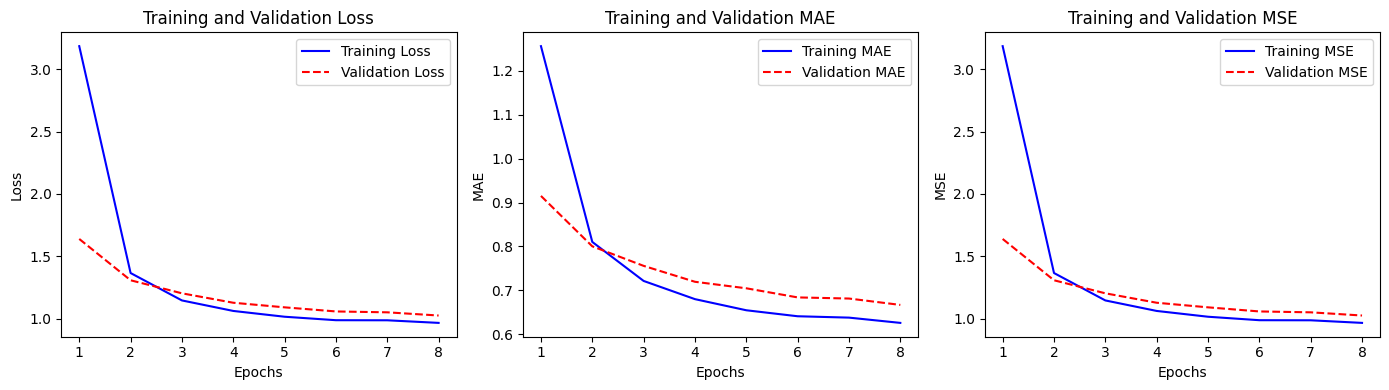

In [50]:
# Extract the history values for plotting
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

epochs = range(1, len(loss) + 1)

# Plot training & validation loss values
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation MAE values
plt.subplot(1, 3, 2)
plt.plot(epochs, mae, 'b-', label='Training MAE')
plt.plot(epochs, val_mae, 'r--', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Plot training & validation MSE values
plt.subplot(1, 3, 3)
plt.plot(epochs, mse, 'b-', label='Training MSE')
plt.plot(epochs, val_mse, 'r--', label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


## 5. Defining the Software Environment

In [51]:
# Specify Requirements

print(f'gdown=={gdown.__version__}')
print(f'h5py=={h5py.__version__}')
print(f'matplotlib=={matplotlib.__version__}')
print(f'nibabel=={nib.__version__}')
print(f'numpy=={np.__version__}')
print(f'pandas=={pd.__version__}')
print(f'pynwb=={pynwb.__version__}')
print(f'pytorch_lightning=={pl.__version__}')
print(f'scipy=={scipy.__version__}')
print(f'seaborn=={sns.__version__}')
print(f'sklearn=={sklearn.__version__}')
print(f'torch=={torch.__version__}')

gdown==4.6.6
h5py==3.9.0
matplotlib==3.7.1
nibabel==4.0.2
numpy==1.23.5
pandas==1.5.3
pynwb==2.5.0
pytorch_lightning==2.1.1
scipy==1.11.3
seaborn==0.12.2
sklearn==1.2.2
torch==2.1.0+cu118


We save this requirements in Github and we will include the command **!pip install -r https://raw.githubusercontent.com/acuadrosr18/Brain-to-Speech-Synthesis-Project_DeepLearning/main/requirements.txt** at the beginning of the notebook.